**We import our data first**

In [1]:
import pandas as pd

df = pd.read_csv('/content/Capstone/AAPL.csv')

In [2]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099450,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094261,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087343,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089504,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092099,73449600
...,...,...,...,...,...,...,...
10755,2023-08-11,177.320007,178.619995,176.550003,177.789993,177.789993,51988100
10756,2023-08-14,177.970001,179.690002,177.309998,179.460007,179.460007,43675600
10757,2023-08-15,178.880005,179.479996,177.050003,177.449997,177.449997,43622600
10758,2023-08-16,177.130005,178.539993,176.500000,176.570007,176.570007,46964900


**We only need the closing price and the date for our model so we drop the other columns**

In [3]:
df = df[['Date', 'Close']]

In [4]:
df

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10755,2023-08-11,177.789993
10756,2023-08-14,179.460007
10757,2023-08-15,177.449997
10758,2023-08-16,176.570007


**We transform our Date column values from strings to datetime objects.**

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)


In [6]:
df['Date'] = df['Date'].apply(str_to_datetime)

<ipython-input-6-82fc7f804c29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [7]:
df

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10755,2023-08-11,177.789993
10756,2023-08-14,179.460007
10757,2023-08-15,177.449997
10758,2023-08-16,176.570007


**Date column becomes the dataframe index.**

In [8]:
df.index = df.pop('Date')

In [9]:
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2023-08-11,177.789993
2023-08-14,179.460007
2023-08-15,177.449997


**We can now see the historical prices of our stocks.**

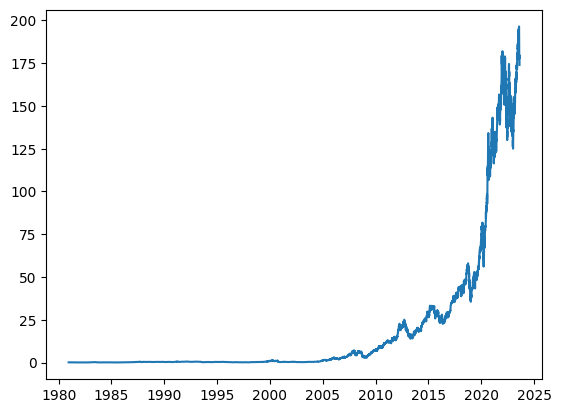

In [10]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

**Our tensorflow model expects the data  in the format output to us by the following function: *df_to_windowed_df***

In [11]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=5):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

The returned dataframe contains 7 columns. For any given date it holds the date (target date), an additional 5 columns labeled Target-N where N represents the number of days back from our target date from 1 to 5 days, and finally the target column containing the closing value of our stock on the target date. You can gather that our model looks 5 days back in order to make a prediction about the closing price on a predicted date.

In [12]:
windowed_df = df_to_windowed_df(df,
                                '1980-12-19',
                                '2023-08-15',
                                 n=5)

In [13]:
windowed_df

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,1980-12-19,0.128348,0.121652,0.112723,0.115513,0.118862,0.126116
1,1980-12-22,0.121652,0.112723,0.115513,0.118862,0.126116,0.132254
2,1980-12-23,0.112723,0.115513,0.118862,0.126116,0.132254,0.137835
3,1980-12-24,0.115513,0.118862,0.126116,0.132254,0.137835,0.145089
4,1980-12-26,0.118862,0.126116,0.132254,0.137835,0.145089,0.158482
...,...,...,...,...,...,...,...
10748,2023-08-09,192.580002,191.169998,181.990005,178.850006,179.800003,178.190002
10749,2023-08-10,191.169998,181.990005,178.850006,179.800003,178.190002,177.970001
10750,2023-08-11,181.990005,178.850006,179.800003,178.190002,177.970001,177.789993
10751,2023-08-14,178.850006,179.800003,178.190002,177.970001,177.789993,179.460007


**Our tensorflow model wants that data in a specific format, we must also divide our data into train and test sets.**

In [14]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((10753,), (10753, 5, 1), (10753,))

**We use 80 percent of our historical data for training, 10 percent for validation,  and the remaining 10 percent for testing.**

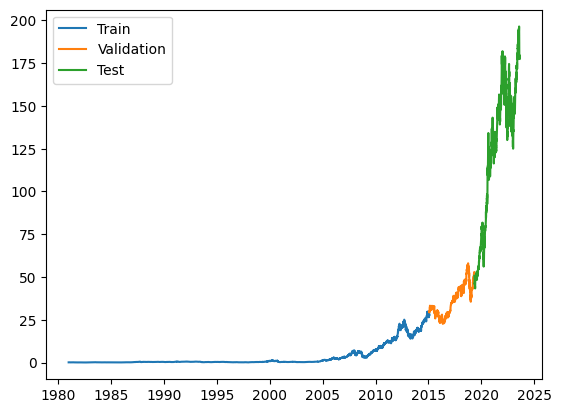

In [15]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

**Our data is ready to be input for our model. We import tenserflow and create a LSTM model. We compile our model and fit it to our data.**
our LSTM is given 64 neurons split onto 2 dense layers and it outputs a single value, the predicted closing price after the 5 days considered.
We compile our model using the mean squared error (mse) as our loss function and setting a small learning rate. We use the mean absolute error as an additional metric. The model runs for 100 epochs

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
269/269 [==============================] - 6s 7ms/step - loss: 6.5515 - mean_absolute_error: 0.6340 - val_loss: 134.0259 - val_mean_absolute_error: 8.3065
Epoch 2/100
269/269 [==============================] - 2s 6ms/step - loss: 0.0284 - mean_absolute_error: 0.0668 - val_loss: 115.8802 - val_mean_absolute_error: 7.4776
Epoch 3/100
269/269 [==============================] - 3s 10ms/step - loss: 0.0241 - mean_absolute_error: 0.0618 - val_loss: 106.9219 - val_mean_absolute_error: 7.0908
Epoch 4/100
269/269 [==============================] - 3s 11ms/step - loss: 0.0234 - mean_absolute_error: 0.0626 - val_loss: 104.0718 - val_mean_absolute_error: 7.1298
Epoch 5/100
269/269 [==============================] - 4s 14ms/step - loss: 0.0201 - mean_absolute_error: 0.0594 - val_loss: 99.6049 - val_mean_absolute_error: 6.9554
Epoch 6/100
269/269 [==============================] - 3s 12ms/step - loss: 0.0197 - mean_absolute_error: 0.0569 - val_loss: 93.9995 - val_mean_absolute_error: 6.5

**We can see our training predictions with our training observations:**

269/269 [==============================] - 1s 2ms/step


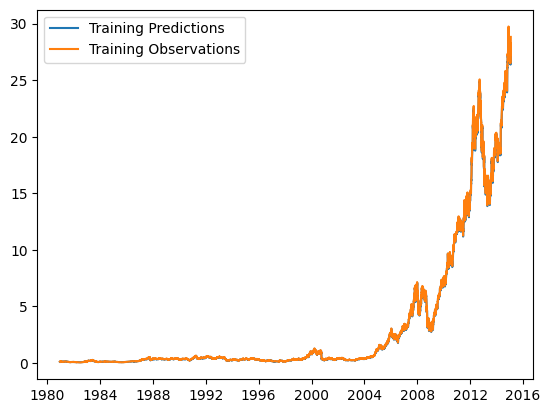

In [17]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

**Our validation predictions vs our validation observations:**

34/34 [==============================] - 0s 2ms/step


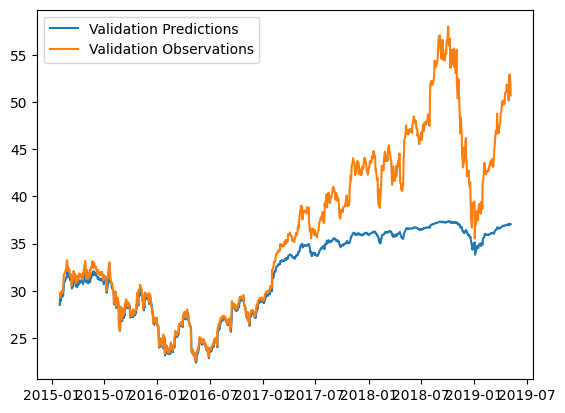

In [18]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

**Our testing predictions vs our testing observations:**

34/34 [==============================] - 0s 4ms/step


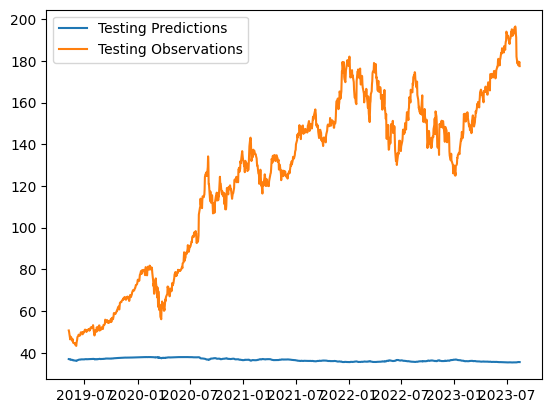

In [19]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

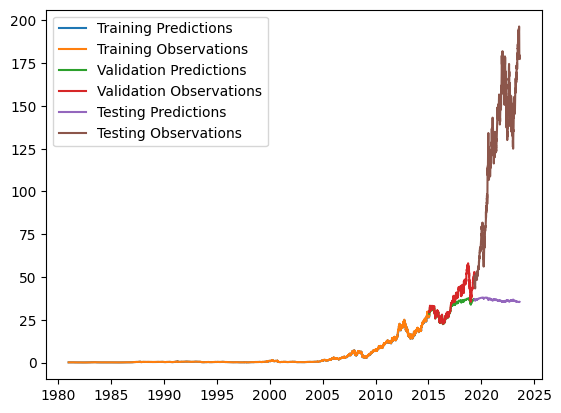

In [20]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

This model demonstrates how LSTM's aren't the best at extrapolating. By using the entire historical price of the stock for our model, we are hindering its predictive power in the near future. Lets see how changing the dataset to the past year changes our results:

In [21]:
windowed_df = df_to_windowed_df(df,
                                '2022-08-15',
                                '2023-08-15',
                                 n=5)
dates, X, y = windowed_df_to_date_X_y(windowed_df)

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)



Epoch 1/100
7/7 [==============================] - 0s 35ms/step - loss: 11254.7832 - mean_absolute_error: 104.9162 - val_loss: 12325.3691 - val_mean_absolute_error: 110.9295
Epoch 2/100
7/7 [==============================] - 0s 18ms/step - loss: 3253.8523 - mean_absolute_error: 53.6616 - val_loss: 2150.8367 - val_mean_absolute_error: 46.1618
Epoch 3/100
7/7 [==============================] - 0s 18ms/step - loss: 521.1927 - mean_absolute_error: 18.9075 - val_loss: 19.3223 - val_mean_absolute_error: 3.6711
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 998.6182 - mean_absolute_error: 28.8495 - val_loss: 519.1686 - val_mean_absolute_error: 22.3405
Epoch 5/100
7/7 [==============================] - 0s 17ms/step - loss: 204.9725 - mean_absolute_error: 11.2692 - val_loss: 2010.8364 - val_mean_absolute_error: 44.6264
Epoch 6/100
7/7 [==============================] - 0s 19ms/step - loss: 312.8475 - mean_absolute_error: 14.4606 - val_loss: 1901.5765 - val_mean_absolute

In [22]:
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()
val_predictions = model.predict(X_val).flatten()


1/1 [==============================] - 0s 26ms/step


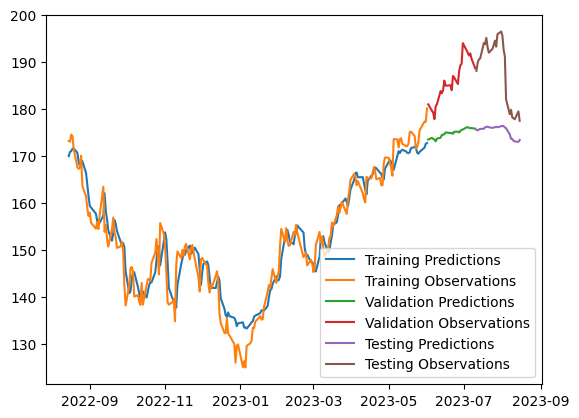

In [23]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

The model does better when trained on more relevant data.